In [108]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage.draw import disk
from scipy import ndimage

In [109]:
# i need to -->
# 1. define the soam
# 2. define the circles
# 3. define the distance between the circles  --> my image is actually is not calibrated thats why my distance will in pixels not in microns;

In [110]:
# the soma detection can be in auto or in manual mode, at first i am gonna do the auto mode;
SOMA_DETECTION_METHOD = "manual"  # Options: "auto" or "manual"

# auto soma detection can be horrible as the machine will assume the brightest spot in the neuron is the soma, which is not true in many cases;


def identify_soma_auto(image):
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(image) #--> acutally minmax is doing that finding out the max(peak) pixel and identifying it
    mask = np.zeros(image.shape, dtype=np.uint8)
    cv2.circle(mask, max_loc, 20, 255, -1)
    moments = cv2.moments(mask)
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    return (cx, cy) # --> returns the coordinates of that specific pixel

In [111]:
def manual_soma_selection(image): # allow manual selection of the soma center via mouse click(like event listeners in js) --> left click on the soma,
    soma_coords = []
    def mouse_callback(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            soma_coords.append((x, y))
            cv2.destroyAllWindows()

    window_name = "Select Soma (Click on the cell body)"
    cv2.namedWindow(window_name)
    cv2.setMouseCallback(window_name, mouse_callback)

    while True:
        cv2.imshow(window_name, image)
        if cv2.waitKey(1) & 0xFF == ord('q') or soma_coords:
            break

    cv2.destroyAllWindows()
    return soma_coords[0] if soma_coords else None

In [112]:
# getting the soma centre 
def get_soma_center(image, method):
    if method == "auto": # automatic soma detection
        return identify_soma_auto(image)
    elif method == "manual": # manual soma detection
        soma_center = manual_soma_selection(image)
        if soma_center is None:
            print("Soma selection cancelled. Using default center.")
            soma_center = (image.shape[1] // 2, image.shape[0] // 2)
        return soma_center
    else:
        raise ValueError("Invalid soma detection method. Choose 'auto' or 'manual'.")

In [113]:
# main code starts frrom here : 

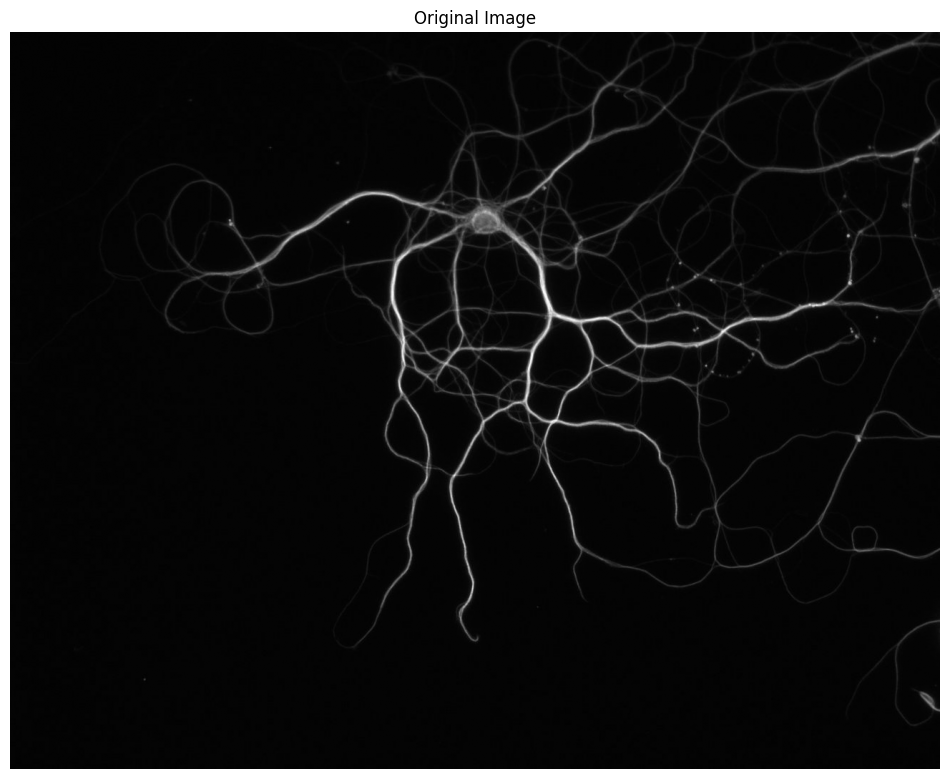

In [139]:
image_path = "Single_Neuron_Database/36185-checkpoint.jpg" #--> the imgae of the neuron
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # turning into greyscale

import cv2
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 12))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

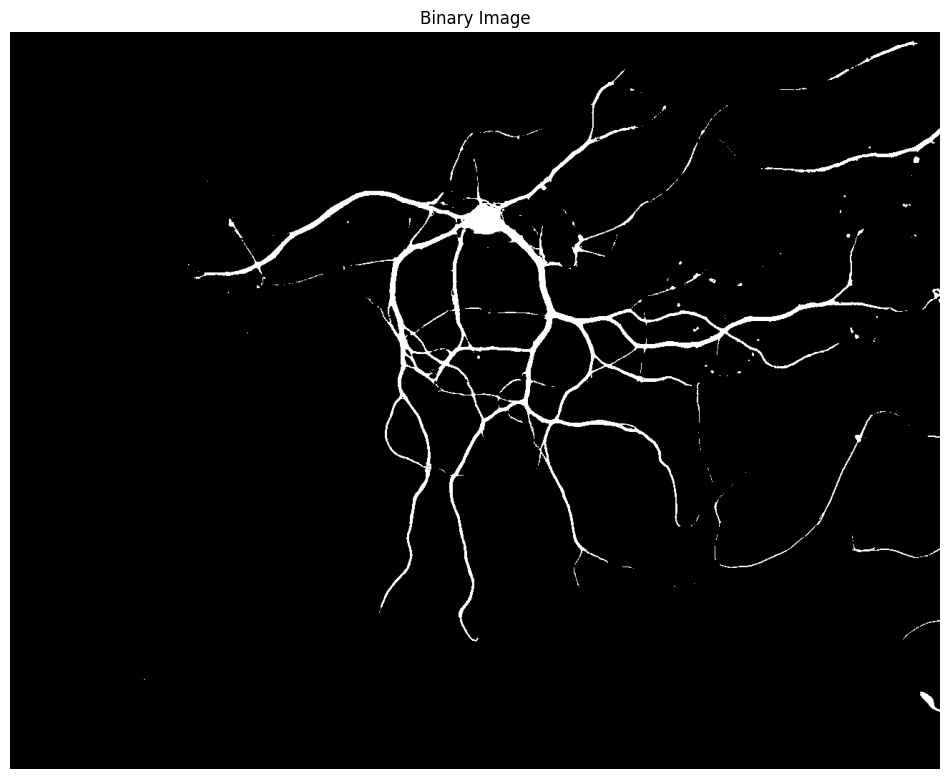

In [115]:
# creating the binary image using Otsu's thresholding
_, binary_img = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU) # cv2.THRESH_OTSU --> done using otsu theshold method --> automatically finds the value for the background/foreground optimallly

plt.figure(figsize=(12, 12))
plt.imshow(binary_img, cmap='gray')
plt.title('Binary Image')
plt.axis('off')
plt.show()


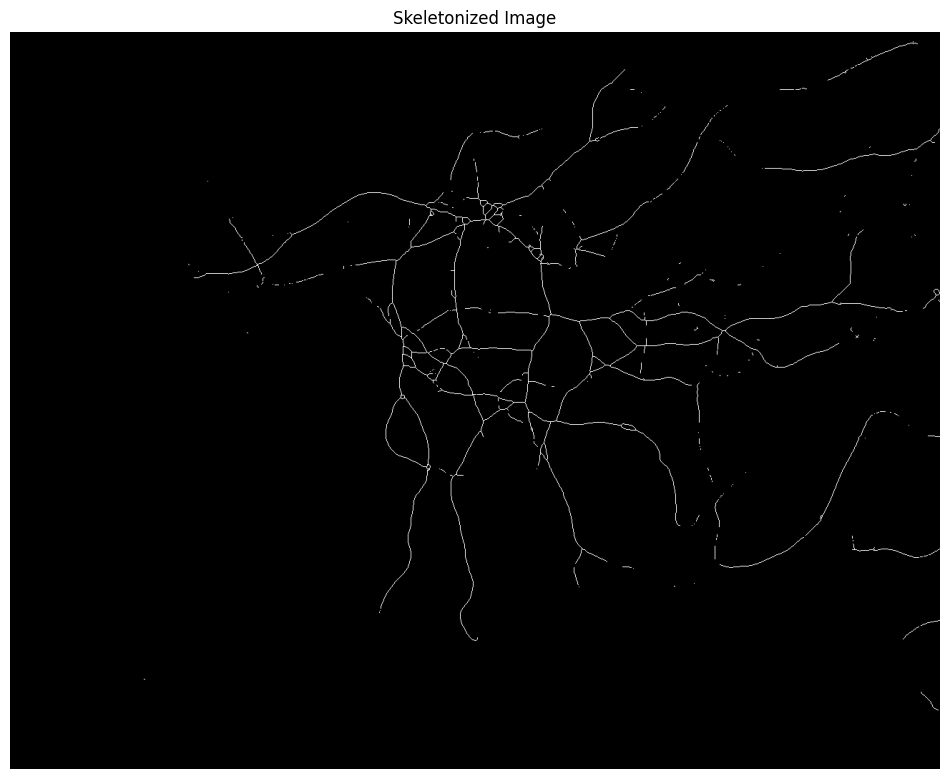

In [116]:
# create a skeletonized version of the binary image -> as some neuron may be thick and osme is thin, i might have breaks in my neuron, i want a generalized form
skeleton = skeletonize(binary_img // 255)

plt.figure(figsize=(12, 12))
plt.imshow(skeleton, cmap='gray')
plt.title('Skeletonized Image')
plt.axis('off')
plt.show()

In [117]:
# finding the soma center using autom or manual
soma_center = get_soma_center(img, SOMA_DETECTION_METHOD)
print(f"Selected soma center: {soma_center}")

Selected soma center: (666, 262)


In [140]:
# now doing the sholl analysis

radius_step = 23  # 20 pixels --> between concentric circles

#max_radius = min(img.shape) // 2  # Maximum radius for analysis

max_radius = int(max(img.shape) * 0.6)  # Use 75% of the larger dimension
# max_radius --> how far i want my circles to go far

In [141]:
radii = np.arange(radius_step, max_radius, radius_step)  # defining the redii using the earlier limits eg, starting value(13) ----> max radius by stepping 13 each time;
intersection_counts = []

In [142]:
#converting a color image to overlay Sholl analysis circles
img_with_circles = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)


In [143]:
# Perform Sholl analysis.

In [144]:
#For each radius in the predefined range, we create a circular mask centered on the soma.

for radius in radii:
    # Create a circular mask
    rr, cc = disk(soma_center, radius, shape=img.shape) #Generate coordinates for a circle of given radius
    circle_mask = np.zeros_like(skeleton, dtype=bool)  #Create a boolean mask where the circle is located
    circle_mask[rr, cc] = 1
    
    # Count intersections between the circle and the skeleton
    #identify where the circle intersects with the neuron's branches.
    intersection = np.logical_and(skeleton, circle_mask) #se a logical AND operation between the skeleton and the circle mask.
    count = np.count_nonzero(intersection) #count the number of non-zero pixels in this intersection, which represents the number of branch intersections at this radius.
    intersection_counts.append(count)  #Add intersection counts to the list. 
    
    # Draw the circle on the image for visualization
    cv2.circle(img_with_circles, soma_center, radius, (0, 255, 0), 1)

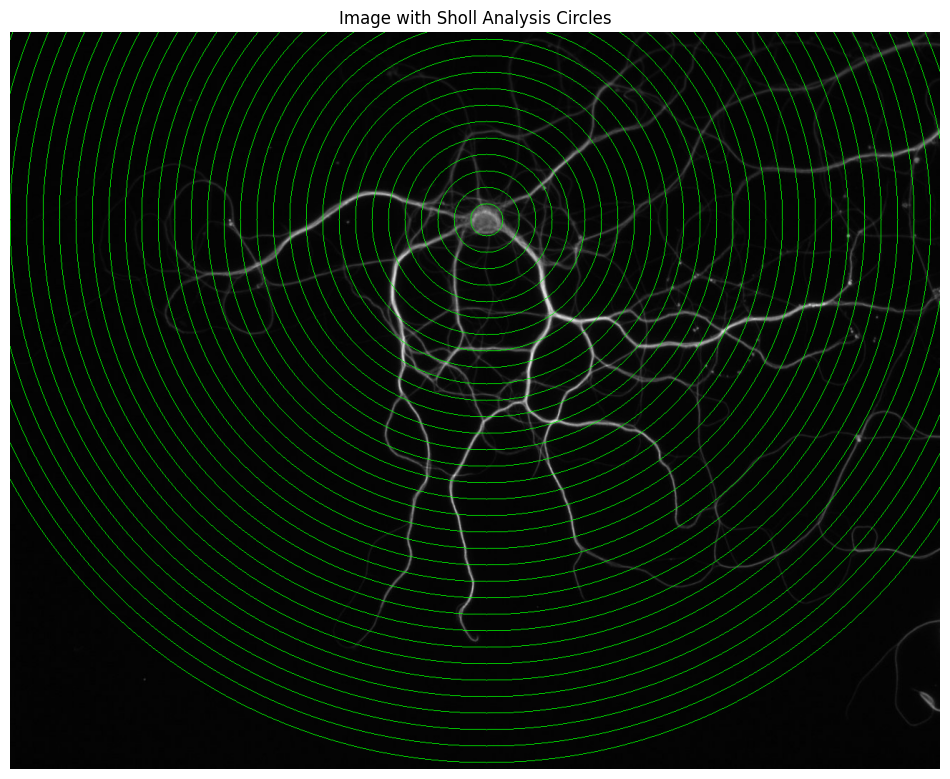

In [145]:
plt.figure(figsize=(12, 12))
plt.imshow(img_with_circles)
plt.title('Image with Sholl Analysis Circles')
plt.axis('off')
plt.show()

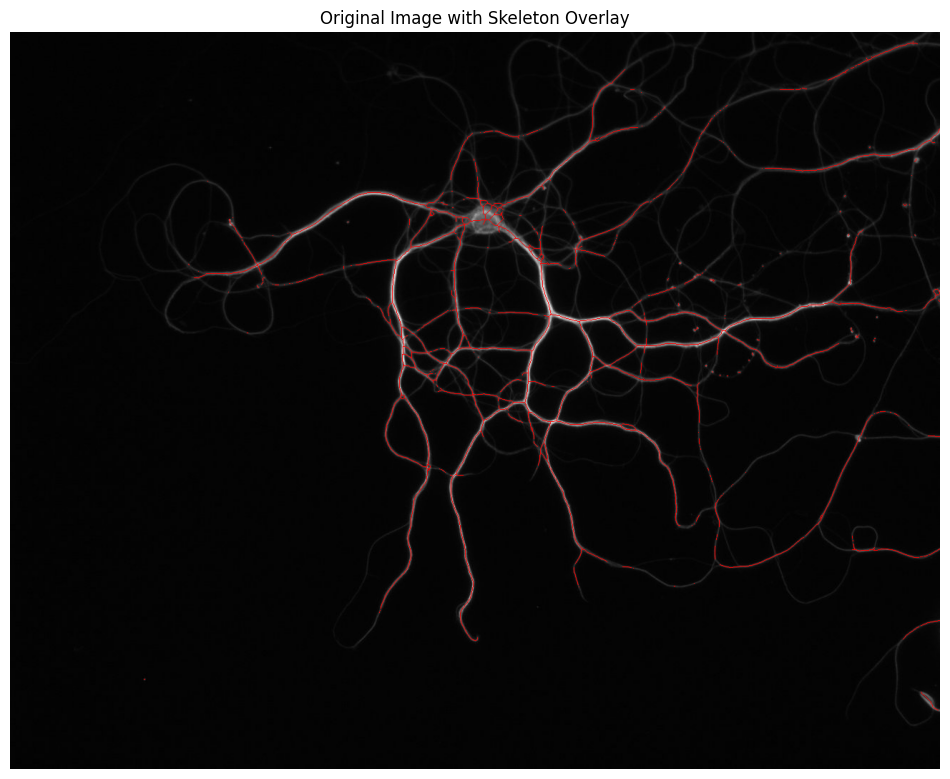

In [146]:
img_with_skeleton_overlay = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
img_with_skeleton_overlay[skeleton == 1] = [255, 0, 0]  # Red color for the skeleton


plt.figure(figsize=(12, 12))
plt.imshow(img_with_skeleton_overlay)
plt.title('Original Image with Skeleton Overlay')
plt.axis('off')
plt.show()


In [147]:
# for the actual sholl analysis : 
# linear fit method (N as a function of Radius).  ---> simple linear regression
# Other type of fits are also often performed, like semi-log regression and log-log regression

In [148]:
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt

In [149]:
# assuming radii and intersection_counts are already defined

def linear_fit(r, *params):
    return sum(param * r**i for i, param in enumerate(params))

degree =4  # Adjust as needed
popt, pcov = optimize.curve_fit(linear_fit, radii, intersection_counts, p0=[1]*(degree+1))

# Calculate R-squared
residuals = intersection_counts - linear_fit(radii, *popt)
ss_res = np.sum(residuals**2)
ss_tot = np.sum((intersection_counts - np.mean(intersection_counts))**2)
r_squared = 1 - (ss_res / ss_tot)

# Calculate standard errors of the parameters
perr = np.sqrt(np.diag(pcov))

Fit Details for Linear Sholl Profile:
Degree of polynomial: 4
Coefficients:
  a0 = 1.1570e+02 ± 1.1727e+02
  a1 = -1.0328e+00 ± 2.0115e+00
  a2 = -1.5529e-02 ± 1.0243e-02
  a3 = 9.5920e-05 ± 1.9543e-05
  a4 = -7.9983e-08 ± 1.2404e-08
R-squared: 0.9977
AIC: 315.4439
BIC: 322.9264


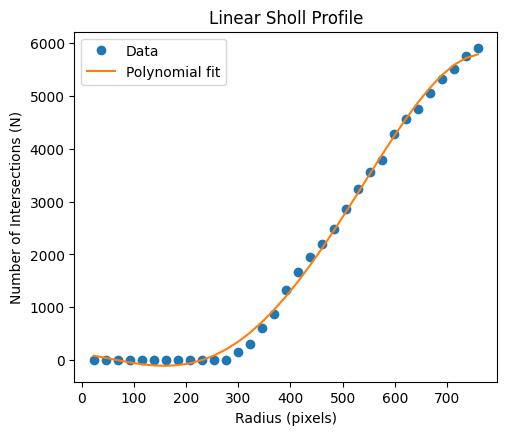

In [150]:
# Plot
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
plt.plot(radii, intersection_counts, 'o', label='Data')
plt.plot(radii, linear_fit(radii, *popt), '-', label='Polynomial fit')
plt.title("Linear Sholl Profile")
plt.xlabel("Radius (pixels)")
plt.ylabel("Number of Intersections (N)")
plt.legend()

# Print fit details
print("Fit Details for Linear Sholl Profile:")
print(f"Degree of polynomial: {degree}")
print("Coefficients:")
for i, (param, err) in enumerate(zip(popt, perr)):
    print(f"  a{i} = {param:.4e} ± {err:.4e}")
print(f"R-squared: {r_squared:.4f}")

# Calculate AIC and BIC
n = len(radii)
k = len(popt)
aic = 2*k + n*np.log(ss_res/n)
bic = np.log(n)*k + n*np.log(ss_res/n)
print(f"AIC: {aic:.4f}")
print(f"BIC: {bic:.4f}")